In [8]:
import glob
import os

import numpy as np
import scipy as sc
import pandas as pd
import geopandas as gpd
import regionmask

import xarray as xr
xr.set_options(keep_attrs=True)
import cf_xarray as cfxr
import rioxarray as rxr

import xcdat as xc
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.animation import FuncAnimation

from cartopy import crs as ccrs
import cartopy

import seaborn as sns

from eofs.xarray import Eof

crs = ccrs.PlateCarree()
crs_proj4 = crs.proj4_init

import colormaps as cmo 

from cdo import *
cdo = Cdo()
cdo.cleanTempDir()

from rich import print as rprint
from tqdm.notebook import tqdm
%load_ext rich

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [9]:
west = 106.4
east = 107.1
north = -5.3
south = -6.2

extent = [west, east, south, north]

In [10]:

din_chl = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/dineofed_chl.nc')

din_06 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/Oa06_dineofed.nc')
din_08 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/Oa08_dineofed.nc')
din_12 = xr.open_dataset('/home/edskywalker/Documents/Programming/Python/Output/IMBER/Data/Oa12_dineofed.nc')

rdi = xr.Dataset()

rdi['rdi'] = ((1 / din_08['Oa08']) - (1 / din_06['Oa06'])) * din_12['Oa12']
rdi['rdi'] = rdi['rdi'].assign_attrs({'long_name': 'Red Tide Index (RDI)'})

mask_ds = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/land_mask.nc')
mask = xr.where(mask_ds['mask'] == 1, np.nan, mask_ds)

### Next

- [ ] Tentukan area yang disinyalir mengalami algal bloom.
- [ ] Buat timeseries RDI


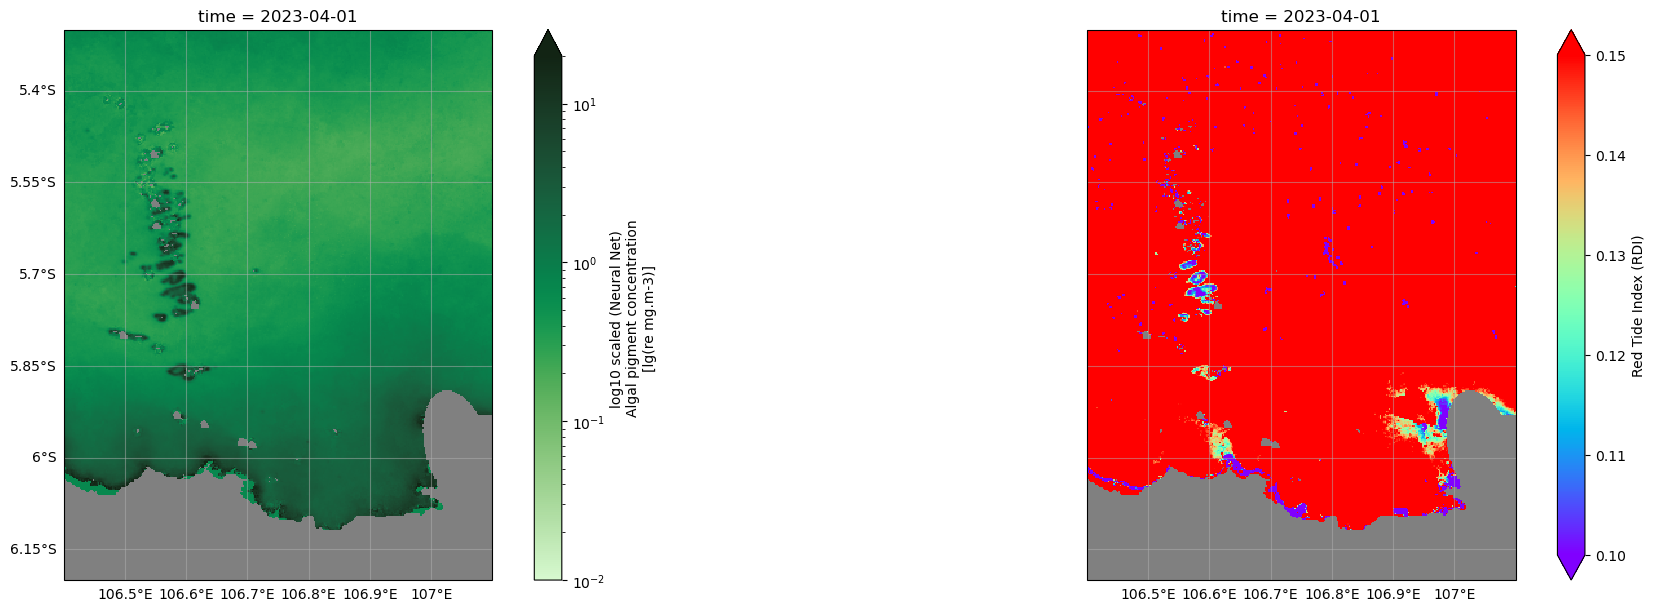

In [14]:
chl_nn = 10 ** din_chl['chl_nn']

fig, ax = plt.subplots(figsize=[12,6], ncols=2, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(2):
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
#    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)
#    ax[i].coastlines()
#    ax[i].add_geometries(land['geometry'], crs=ccrs.PlateCarree(), zorder = 1, facecolor='beige', edgecolor='darkgrey')
    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False

    mask['mask'].plot(ax=ax[i], zorder=1, cmap = cmo.gray, add_colorbar=False, transform=ccrs.PlateCarree())

    if not i == 0:
        ini.left_labels = False


chl_nn.sel(time='2023-04-01').plot(ax=ax[0], norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder = 0, transform=ccrs.PlateCarree())
rdi['rdi'].sel(time='2023-04-01').plot(ax=ax[1], norm=colors.Normalize(0.10,0.15), cmap=cmo.rainbow, zorder = 0, transform=ccrs.PlateCarree())

In [12]:
chl_1 = din_chl.sel(lon=slice(106.9,107.05), lat=slice(-6.11, -6.0)).mean(dim=['lon','lat'])
rdi_1 = rdi.sel(lon=slice(106.9,107.05), lat=slice(-6.11, -6.0)).mean(dim=['lon','lat'])
rprint(rdi_1)

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 148)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2017-11-01 2017-11-15 ... 2023-12-15
Data variables:
    rdi      (time) float64 1kB nan nan nan nan nan nan ... nan nan nan nan nan

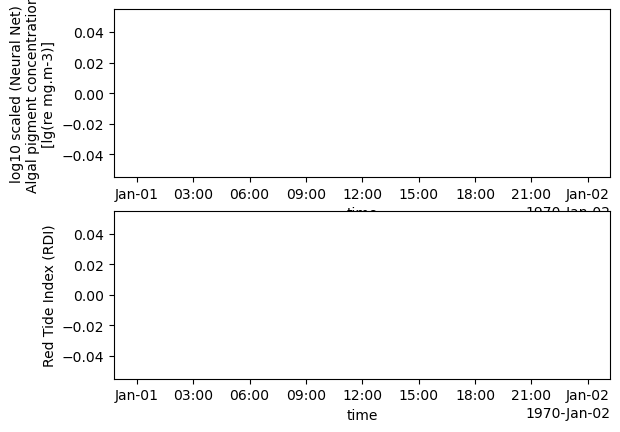

In [13]:
fig, ax = plt.subplots(nrows=2)

chl_1.chl_nn.plot(ax=ax[0])
rdi_1.rdi.plot(ax=ax[1])

In [15]:
tes = rxr.open_rasterio('/home/edskywalker/Documents/Resources/PIA03395.tif')

tes

/home/edskywalker/.miniconda3/envs/eds/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 3, y: 9049, x: 21600)> Size: 586MB
[586375200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 173kB 0.5 1.5 2.5 ... 2.16e+04 2.16e+04 2.16e+04
  * y            (y) float64 72kB 0.5 1.5 2.5 ... 9.046e+03 9.048e+03 9.048e+03
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DATETIME:        2003:08:20 15:58:15
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        Adobe Photoshop 7.0
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    scale_factor:            1.0
    add_offset:              0.0